### HDB Dashboard Creation Workflow

In [1]:
import os
import json
import requests
import pandas as pd
import plotly.graph_objects as go

#### Setting up dates for data extraction 

In [3]:
mths_2012_14 = list()
year = range(2013, 2015, 1)
months = range(1, 13, 1)

for yr in year:
    for month in months:
        month = str(month).zfill(2) 
        mths_2012_14.append(f"{yr}-{month}")
        
mths_2015_16 = list()
year = range(2015, 2017, 1)
months = range(1, 13, 1)

for yr in year:
    for month in months:
        month = str(month).zfill(2) 
        mths_2015_16.append(f"{yr}-{month}")
        
mths_2017_onwards = list()
year = range(2017, 2030, 1)
months = range(1, 13, 1)

for yr in year:
    for month in months:
        month = str(month).zfill(2) 
        mths_2017_onwards.append(f"{yr}-{month}")

mth_filter = mths_2017_onwards.index('2024-06')
mths_2017_onwards = mths_2017_onwards[:mth_filter+1]

In [4]:
df_cols = ['month', 'town', 'floor_area_sqm', 'flat_type', 'lease_commence_date', 'resale_price' ]
param_fields = ",".join(df_cols)

In [5]:
mth_2012_2014 = "?resource_id=d_2d5ff9ea31397b66239f245f57751537"
base_url = "https://data.gov.sg/api/action/datastore_search"
url = base_url + mth_2012_2014

latest_df = pd.DataFrame()
for mth in mths_2012_14:
    params = {
        "fields": param_fields,
        "filters": json.dumps({'month': mth}),
        "limit": 10000
    }
    response = requests.get(url, params=params)
    mth_df = pd.DataFrame(response.json().get("result").get("records"))  
    latest_df = pd.concat([latest_df, mth_df], axis=0)

  0%|          | 0/24 [00:00<?, ?it/s]

In [6]:
mth_2015_2016 = "?resource_id=d_ea9ed51da2787afaf8e51f827c304208"
base_url = "https://data.gov.sg/api/action/datastore_search"
url = base_url + mth_2015_2016

for mth in mths_2015_16:
    params = {
        "fields": param_fields,
        "filters": json.dumps({'month': mth}),
        "limit": 10000
    }
    response = requests.get(url, params=params)
    mth_df = pd.DataFrame(response.json().get("result").get("records"))  
    latest_df = pd.concat([latest_df, mth_df], axis=0)

  0%|          | 0/24 [00:00<?, ?it/s]

In [7]:
mth_2017 = "?resource_id=d_8b84c4ee58e3cfc0ece0d773c8ca6abc"
base_url = "https://data.gov.sg/api/action/datastore_search"
url = base_url + mth_2017

for mth in mths_2017_onwards:
    params = {
        "fields": param_fields,
        "filters": json.dumps({'month': mth}),
        "limit": 10000
    }
    response = requests.get(url, params=params)
    mth_df = pd.DataFrame(response.json().get("result").get("records"))   
    latest_df = pd.concat([latest_df, mth_df], axis=0)

  0%|          | 0/90 [00:00<?, ?it/s]

### Data Processing for creating charts 

In [8]:
df = latest_df.copy()
df['yr_q'] = [str(i) for i in pd.to_datetime(df['month']).dt.to_period('Q')]
df['count'] = 1
df.rename(columns={'resale_price':'price'}, inplace=True)
df.price = df.price.astype(float)

# Create price categories
bins = [0, 300000, 500000, 800000, 1000000, 2000000]
labels = ["<=300k", "300-500k", "500-800k", "800k-1m", ">=1m"]
df["price_grp"] = pd.cut(df["price"], bins=bins, labels=labels, right=False)

chart_width = 1000
chart_height = 600

### My Graphs
1. [Home Price Distributions](#Home-price-distributions) - Tracking price distribution of public homes sold
1. [Advanced Million Dollar Homes](#Advanced-Million-Dollar-Homes) - Tracking million dollar homes and their porportions
1. [Stacked Bar Values](#Stacked-Bar-Values) - Tracking number of public homes sold by their price brackets
1. [Stacked Bar Percentage](#Stacked-Bar-Percentage) - Tracking proportion of public homes sold by their price brackets

### Home price distributions
#### [Back to My Graphs](#My-Graphs)

In [9]:
period = 'yr_q'
fig = go.Figure()
for p in df[period].drop_duplicates():
    fig.add_trace(go.Box(y=df[df[period] == p].price, name=str(p)))

fig.update_layout(
    title='By Quarters - Public Home Price Distributions From 2013',
    yaxis={"title": "Home Prices"},
    xaxis={"title": "Quarters"},
    width=chart_width, height=chart_height,
    showlegend=False,
)

fig.write_html("qtr_boxplot.html")
# fig.show()

In [10]:
period = 'month'
fig = go.Figure()

mth_df = df[df.yr_q >= '2020Q1']
for p in mth_df[period].drop_duplicates():
    fig.add_trace(go.Box(y=mth_df[mth_df[period] == p].price, name=str(p)))

fig.update_layout(
    title='By Months - Public Home Price Distributions From 2020',
    yaxis={"title": "Home Prices"},
    xaxis={"title": "Months"},
    width=chart_width, height=chart_height,
    showlegend=False,
)

fig.write_html("mth_boxplot.html")
# fig.show()

### Advanced Million Dollar Homes
#### [Back to My Graphs](#My-Graphs)

In [19]:
period = 'yr_q'
df['mil'] = [1 if i >= 1000000 else 0 for i in df['price']]
for_plot = df.groupby([period, 'mil'])['town'].count().reset_index().sort_values(period)
cal_ = for_plot.pivot_table(index=period, values='town', columns='mil', 
                            margins=True, aggfunc="sum").reset_index().fillna(0)

for i in [0, 1, 'All']:
    cal_[i] = cal_[i].astype(int)

cal_['proportion'] = [round(i,2) for i in cal_[1] / cal_['All'] * 100]
cal_mil_ts = cal_[cal_[period] != 'All'].reset_index(drop=True)
cal_mil_ts.columns = [period, '0', 'million $ Trans', 'Total Trans', '% million Trans']

In [20]:
from plotly.subplots import make_subplots
fig = make_subplots(specs=[[{"secondary_y": True}]])

title = "By Quarters - % of Million Dollar Public Home Sales [Line] & Total Sales Public Home Sales [Bar] "
fig.add_trace(go.Scatter(
    x=cal_mil_ts[period], 
    y=cal_mil_ts['% million Trans'],
    mode='lines+markers',
    name="%"), 
secondary_y=False)

fig.add_trace(go.Bar(
    x=cal_mil_ts[period],
    y=cal_mil_ts['0'],
    opacity=.4,
    name="Total Sales"),
secondary_y=True)

fig.update_layout(
    title=title,
    hovermode="x unified",
    xaxis={"title": "Quarters"},
    width=chart_width, height=chart_height,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig.update_yaxes(title_text="% Million Dollar Homes to Overall Sales", secondary_y=False)
fig.update_yaxes(title_text="Total Sales", secondary_y=True)

fig.add_hline(y=1, line_width=1.5, line_dash="dash", line_color="black")
fig.add_hline(y=1.5, line_width=1.5, line_dash="dash", line_color="red")

fig.write_html("qtr_barline_chart.html")
# fig.show()

In [21]:
period = 'month'
df['mil'] = [1 if i >= 1000000 else 0 for i in df['price']]
for_plot = df[df.yr_q >= '2020Q1'].groupby([period, 'mil'])['town'].count().reset_index().sort_values(period)
cal_ = for_plot.pivot_table(index=period, values='town', columns='mil', 
                            margins=True, aggfunc="sum").reset_index().fillna(0)

for i in [0, 1, 'All']:
    cal_[i] = cal_[i].astype(int)

cal_['proportion'] = [round(i,2) for i in cal_[1] / cal_['All'] * 100]
cal_mil_ts = cal_[cal_[period] != 'All'].reset_index(drop=True)
cal_mil_ts.columns = [period, '0', 'million $ Trans', 'Total Trans', '% million Trans']

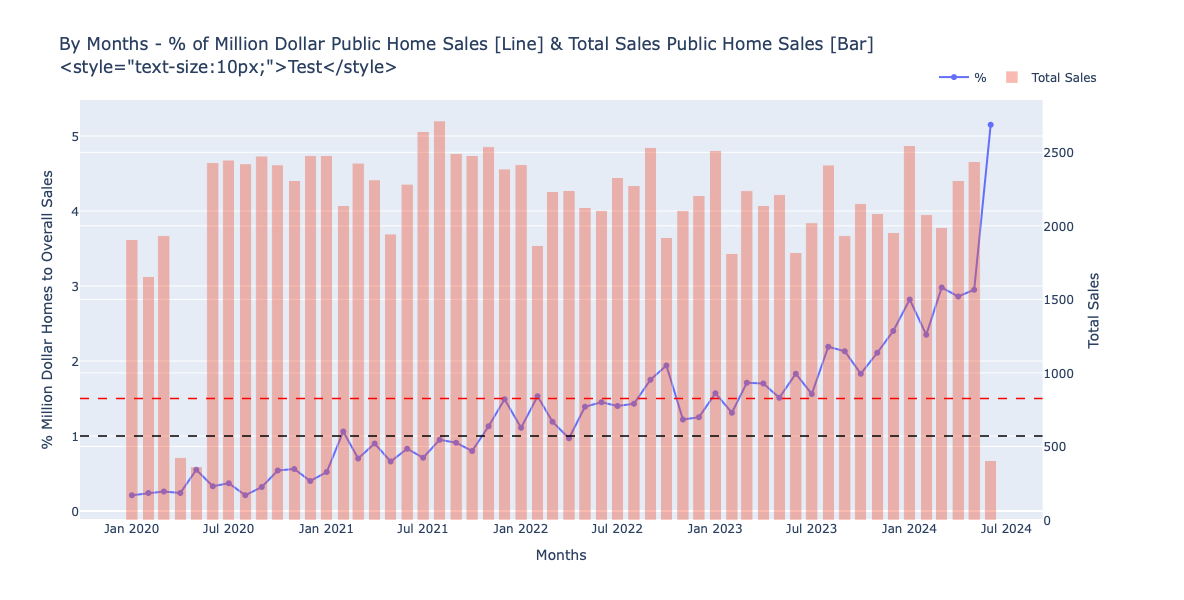

In [31]:
from plotly.subplots import make_subplots
fig = make_subplots(specs=[[{"secondary_y": True}]])

title = """By Months - % of Million Dollar Public Home Sales [Line] & Total Sales Public Home Sales [Bar]"""
fig.add_trace(go.Scatter(
    x=cal_mil_ts[period], 
    y=cal_mil_ts['% million Trans'],
    mode='lines+markers',
    name="%"), 
secondary_y=False)

fig.add_trace(go.Bar(
    x=cal_mil_ts[period],
    y=cal_mil_ts['0'],
    opacity=.4,
    name="Total Sales"),
secondary_y=True)

fig.update_layout(
    title=title,
    hovermode="x unified",
    xaxis={"title": "Months"},
    width=chart_width, height=chart_height,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig.update_yaxes(title_text="% Million Dollar Homes to Overall Sales", secondary_y=False)
fig.update_yaxes(title_text="Total Sales", secondary_y=True)

fig.add_hline(y=1, line_width=1.5, line_dash="dash", line_color="black")
fig.add_hline(y=1.5, line_width=1.5, line_dash="dash", line_color="red")

# fig.write_html("mth_barline_chart.html")
fig.show()

### Stacked Bar Values
#### [Back to My Graphs](#My-Graphs)

In [15]:
period = 'yr_q'
price_grp_plots = df.groupby([period, 'price_grp'])['count'].sum().reset_index()

fig = go.Figure()
data = list()
for i in price_grp_plots.price_grp.drop_duplicates().tolist():
    fig.add_trace(go.Bar(name=i, 
                         x=price_grp_plots[price_grp_plots.price_grp == i][period].tolist(), 
                         y=price_grp_plots[price_grp_plots.price_grp == i]['count'].tolist()
                        )
                 )

fig.update_layout(
    barmode='stack',
    xaxis={'title':'Quarters'},
    yaxis={'title':'Count'},
    hovermode="x unified",
    title="By Quarters - No. of Public Home Resales by Price Categories from 2013",
    width=chart_width, height=chart_height,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
))

fig.write_html("qtr_stack_bar_values.html")
# fig.show()

In [16]:
period = 'month'
price_grp_plots = df[df.yr_q >= '2020Q1'].groupby([period, 'price_grp'])['count'].sum().reset_index()

fig = go.Figure()
data = list()
for i in price_grp_plots.price_grp.drop_duplicates().tolist():
    fig.add_trace(go.Bar(name=i, 
                         x=price_grp_plots[price_grp_plots.price_grp == i][period].tolist(), 
                         y=price_grp_plots[price_grp_plots.price_grp == i]['count'].tolist()
                        )
                 )

fig.update_layout(
    barmode='stack',
    xaxis={'title':'Months'},
    yaxis={'title':'Count'},
    hovermode="x unified",
    title="By Months - No. of Public Home Resales by Price Categories from 2020",
    width=chart_width, height=chart_height,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig.write_html("mth_stack_bar_values.html")
# fig.show()

### Stacked Bar Percentage
#### [Back to My Graphs](#My-Graphs)

In [17]:
period = 'yr_q'
price_grp_base = df.groupby(period)['count'].sum().reset_index()
price_grp_plots = df.groupby([period, 'price_grp'])['count'].sum().reset_index()
price_grp_plots_v2 = price_grp_plots.merge(price_grp_base, on=period)
price_grp_plots_v2.columns = [period, 'price_grp', 'count', 'total']
price_grp_plots_v2['percent_count'] = [round(i * 100, 1) for i in price_grp_plots_v2['count'] / price_grp_plots_v2['total']]

fig = go.Figure()
data = list()
for i in price_grp_plots_v2.price_grp.drop_duplicates().tolist():
    fig.add_trace(go.Bar(name=i, 
                         x=price_grp_plots_v2[price_grp_plots_v2.price_grp == i][period].tolist(), 
                         y=price_grp_plots_v2[price_grp_plots_v2.price_grp == i]['percent_count'].tolist(),
                        ))
fig.add_hline(y=50, line_width=1.5, line_dash="dash", line_color="purple")
fig.update_layout(
    barmode='stack', 
    title="By Quarters - % of Public Home Sales by Price Categories from 2013",
    xaxis={'title':'Quarters'},
    yaxis={'title':'%'},
    hovermode="x unified",
    width=chart_width, height=chart_height,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig.write_html("qtr_stack_bar_percent.html")
# fig.show()

In [18]:
period = 'month'
mth_df = df[df.yr_q >= '2020Q1']
price_grp_base = mth_df.groupby(period)['count'].sum().reset_index()
price_grp_plots = mth_df.groupby([period, 'price_grp'])['count'].sum().reset_index()
price_grp_plots_v2 = price_grp_plots.merge(price_grp_base, on=period)
price_grp_plots_v2.columns = [period, 'price_grp', 'count', 'total']
price_grp_plots_v2['percent_count'] = [round(i * 100, 1) for i in price_grp_plots_v2['count'] / price_grp_plots_v2['total']]

fig = go.Figure()
data = list()
for i in price_grp_plots_v2.price_grp.drop_duplicates().tolist():
    fig.add_trace(go.Bar(name=i, 
                         x=price_grp_plots_v2[price_grp_plots_v2.price_grp == i][period].tolist(), 
                         y=price_grp_plots_v2[price_grp_plots_v2.price_grp == i]['percent_count'].tolist(),
                        ))
fig.add_hline(y=50, line_width=1.5, line_dash="dash", line_color="purple")
fig.update_layout(
    barmode='stack', 
    title="By Months - % of Public Home Sales by Price Categories from 2013",
    xaxis={'title':'Months'},
    yaxis={'title':'%'},
    hovermode="x unified",
    width=chart_width, height=chart_height,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig.write_html("mth_stack_bar_percent.html")
# fig.show()